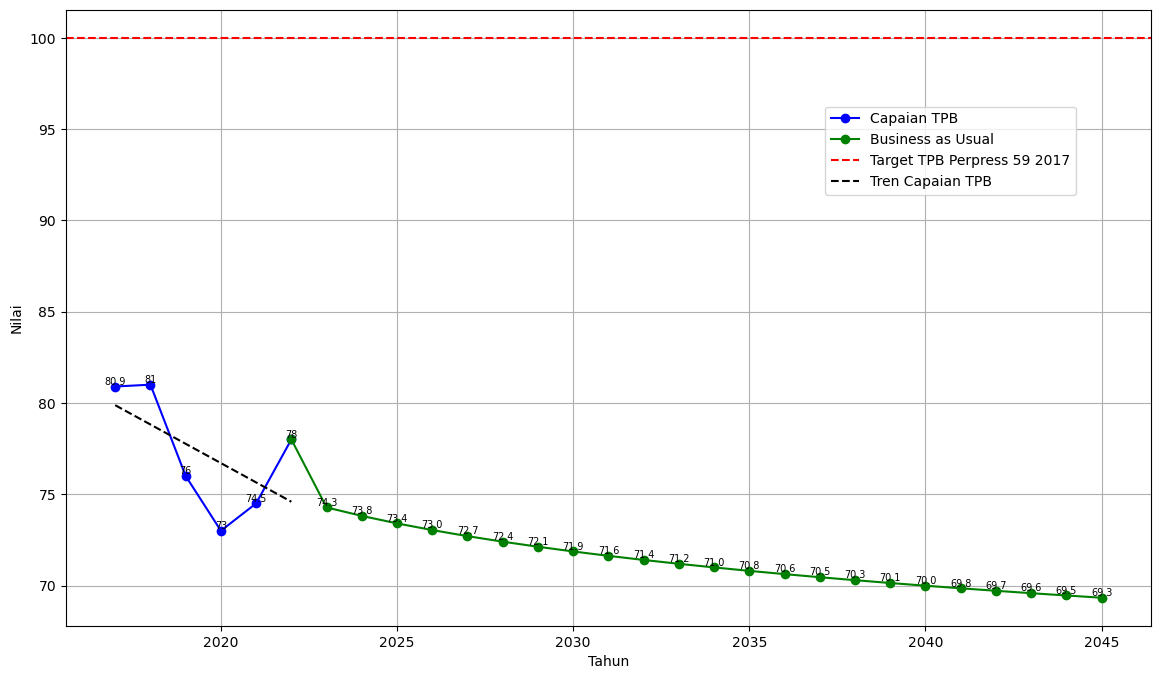

In [91]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Fungsi untuk model regresi logaritmik
def regresi_logaritmik(x, beta_0, beta_1):
    return beta_0 + beta_1 * np.log(x)

# Membaca file Excel dengan semua sheet
xls = pd.ExcelFile('Capaian_TPB2.xlsx')

# Membaca data dari semua sheet dan menyimpannya dalam dictionary
data_dict = {sheet_name: pd.read_excel(xls, sheet_name) for sheet_name in xls.sheet_names}

# Misalnya, kita ambil data dari sheet 'Data1'
# Sesuaikan dengan nama sheet yang Anda miliki

# Mendapatkan data dari sheet 'Data1'
df = data_dict['1.1.1']

# Mengambil nilai Tahun dan Capaian TPB dari DataFrame
x_data = df['Tahun'].values
y_data = df['Capaian TPB'].values

# Menyesuaikan data x untuk menghindari logaritma dari nol
x_data_terkoreksi = x_data - x_data.min() + 1  # Asumsi tahun pertama tidak pernah 0

# Menyesuaikan model regresi logaritmik ke data historis
popt, pcov = curve_fit(regresi_logaritmik, x_data_terkoreksi, y_data, maxfev=10000)

# Proyeksikan nilai menggunakan model yang disesuaikan
tahun_proyeksi = np.arange(x_data[-1] + 1, 2046)
x_proyeksi_terkoreksi = tahun_proyeksi - x_data.min() + 1
y_proyeksi = regresi_logaritmik(x_proyeksi_terkoreksi, *popt)
#y_proyeksi_logaritmik = np.clip(y_proyeksi, None, 100) # pilih jika ingin dibatasi sampai 100
y_proyeksi_logaritmik = np.maximum(y_proyeksi, 0) # pilih jika ingin dibatasi sampai 0
#y_proyeksi_logaritmik = y_proyeksi # pilih jika tidak ada batasan

# Menambahkan garis tren linear capaian TPB
z = np.polyfit(x_data, y_data, 1)
p = np.poly1d(z)

# Visualisasi
plt.figure(figsize=(14, 8))
plt.plot(x_data, y_data, 'o-', color='blue', label='Capaian TPB')
plt.plot(np.concatenate(([x_data[-1]], tahun_proyeksi)), np.concatenate(([y_data[-1]], y_proyeksi_logaritmik)), 'o-', color='green', label='Business as Usual')
plt.axhline(100, color='red', linestyle='--', label='Target TPB Perpress 59 2017')

for x, y in zip(np.concatenate((x_data, tahun_proyeksi)), np.concatenate((y_data, y_proyeksi_logaritmik))):
    label = f"{int(y)}" if y % 1 == 0 else f"{y:.1f}"
    plt.text(x, y, label, fontsize=7, ha='center', va='bottom')

plt.plot(x_data, p(x_data), color='black', linestyle='--', label='Tren Capaian TPB')
plt.xlabel('Tahun')
plt.ylabel('Nilai')
plt.legend(loc=(0.7, 0.7))
plt.grid(True)

# Menyimpan gambar
#plt.savefig('capaian_tpb_proyeksi.png')

# Menampilkan plot
plt.show()

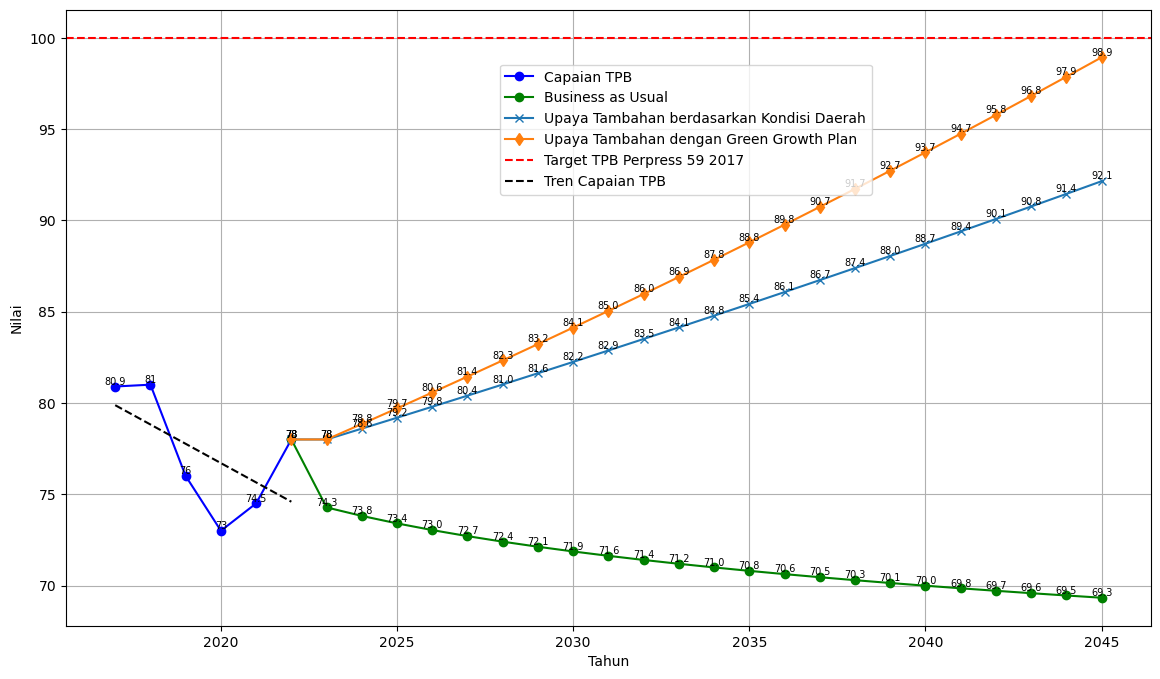

In [92]:
# Pengaturan target untuk proyeksi
tahun_target = 2045
nilai_target = 100
tahun_ke_target = tahun_target - x_data[-1]

# Bobot asumsi dan pencapaian persentase
bobot_asumsi = {
    "kondisi daya dukung": 0.333333,
    "kondisi keuangan": 0.333333,
    "kolaborasi mitra": 0.333333
}
persentase_pencapaian = {
    "kondisi daya dukung": 70,
    "kondisi keuangan": 70,
    "kolaborasi mitra": 70
}

# Menghitung pengaruh total
pengaruh_total = sum(bobot_asumsi[asumsi] * (persentase_pencapaian[asumsi] / 100) for asumsi in bobot_asumsi)

# Fungsi untuk menghitung laju pertumbuhan dengan pengaruh dan memproyeksikan nilai tahunan
def hitung_laju_pertumbuhan_dengan_pengaruh(nilai_terakhir_diketahui, nilai_target, tahun_ke_target, pengaruh_total):
    laju_pertumbuhan_diperlukan = (nilai_target / nilai_terakhir_diketahui) ** (1 / tahun_ke_target) - 1
    return laju_pertumbuhan_diperlukan * pengaruh_total

def proyeksikan_nilai(nilai_awal, laju_pertumbuhan, tahun):
    return [nilai_awal * ((1 + laju_pertumbuhan) ** tahun) for tahun in range(tahun + 1)]

# Persentase pencapaian disesuaikan untuk proyeksi spesifik (GGP)
persentase_pencapaian_ggp_spesifik = {
    "kondisi daya dukung": 100,
    "kondisi keuangan": 100,
    "kolaborasi mitra": 100
}

# Menghitung pengaruh total untuk proyeksi GGP spesifik
pengaruh_total_ggp_spesifik = sum(bobot_asumsi[asumsi] * (persentase_pencapaian_ggp_spesifik[asumsi] / 100) for asumsi in bobot_asumsi)

# Menghitung laju pertumbuhan untuk kedua proyeksi umum dan GGP spesifik
laju_pertumbuhan_ggp_spesifik = hitung_laju_pertumbuhan_dengan_pengaruh(y_data[-1], nilai_target, tahun_ke_target, pengaruh_total_ggp_spesifik)
laju_pertumbuhan_dengan_pengaruh_disesuaikan = hitung_laju_pertumbuhan_dengan_pengaruh(y_data[-1], nilai_target, tahun_ke_target, pengaruh_total)

# Menghitung nilai proyeksi untuk kedua proyeksi
tahun_proyeksi = np.arange(x_data[-1] + 1, tahun_target + 1)
nilai_proyeksi_ggp_spesifik = proyeksikan_nilai(y_data[-1], laju_pertumbuhan_ggp_spesifik, tahun_ke_target - 1)
nilai_proyeksi_dengan_pengaruh_disesuaikan = proyeksikan_nilai(y_data[-1], laju_pertumbuhan_dengan_pengaruh_disesuaikan, tahun_ke_target - 1)

# Visualisasi dengan dimensi yang sudah diperbaiki
plt.figure(figsize=(14, 8))
plt.plot(x_data, y_data, 'o-', color='blue', label='Capaian TPB')
plt.plot(np.concatenate(([x_data[-1]], tahun_proyeksi)), np.concatenate(([y_data[-1]], y_proyeksi_logaritmik)), 'o-', color='green', label='Business as Usual')
plt.plot(np.concatenate(([x_data[-1]], tahun_proyeksi)), np.concatenate(([y_data[-1]], nilai_proyeksi_dengan_pengaruh_disesuaikan)), 'x-', label='Upaya Tambahan berdasarkan Kondisi Daerah')
plt.plot(np.concatenate(([x_data[-1]], tahun_proyeksi)), np.concatenate(([y_data[-1]], nilai_proyeksi_ggp_spesifik)), 'd-', label='Upaya Tambahan dengan Green Growth Plan')

plt.axhline(nilai_target, color='red', linestyle='--', label='Target TPB Perpress 59 2017')

for x, y in zip(np.concatenate((x_data, tahun_proyeksi)), np.concatenate((y_data, y_proyeksi_logaritmik))):
    label = f"{int(y)}" if y % 1 == 0 else f"{y:.1f}"
    plt.text(x, y, label, fontsize=7, ha='center', va='bottom')

for x, y in zip(np.concatenate(([x_data[-1]], tahun_proyeksi)), np.concatenate(([y_data[-1]], nilai_proyeksi_dengan_pengaruh_disesuaikan))):
    label = f"{int(y)}" if y % 1 == 0 else f"{y:.1f}"
    plt.text(x, y, label, fontsize=7, ha='center', va='bottom')

for x, y in zip(np.concatenate(([x_data[-1]], tahun_proyeksi)), np.concatenate(([y_data[-1]], nilai_proyeksi_ggp_spesifik))):
    label = f"{int(y)}" if y % 1 == 0 else f"{y:.1f}"
    plt.text(x, y, label, fontsize=7, ha='center', va='bottom')
    
plt.plot(x_data, p(x_data), color='black', linestyle='--', label='Tren Capaian TPB') 
plt.xlabel('Tahun')
plt.ylabel('Nilai')
plt.legend(loc=(0.4, 0.7))
plt.grid(True)

# Menyimpan gambar
#plt.savefig('capaian_tpb_proyeksi2.png')

# Menampilkan plot
plt.show()

In [2]:
import os
import pandas as pd
from openpyxl import load_workbook
from openpyxl import Workbook
from zipfile import BadZipFile

# Membuat DataFrame untuk data proyeksi
df_proyeksi = pd.DataFrame({
    "Tahun": tahun_proyeksi,
    "Business as Usual": y_proyeksi_logaritmik,
    "Upaya Tambahan berdasarkan Kondisi Daerah": nilai_proyeksi_dengan_pengaruh_disesuaikan,
    "Upaya Tambahan dengan Green Growth Plan": nilai_proyeksi_ggp_spesifik
}).round(2)

# Tentukan path lengkap ke file Excel
nama_file = 'Output Proyeksi.xlsx'
direktori = './'
path_lengkap = os.path.join(direktori, nama_file)

# Pastikan direktori ada
if not os.path.exists(direktori):
    os.makedirs(direktori)

# Cek apakah file Excel sudah ada dan valid
file_valid = os.path.exists(path_lengkap) and os.path.getsize(path_lengkap) > 0

if file_valid:
    try:
        workbook = load_workbook(path_lengkap)
    except BadZipFile:
        print("File Excel tidak valid atau rusak.")
        workbook = None
else:
    workbook = Workbook()
    workbook.save(path_lengkap)  # Simpan file Excel baru

# Menentukan nama sheet baru
nama_sheet_baru = "1.1.6"

# Mengecek apakah nama sheet baru sudah ada di workbook
if workbook is not None:
    if nama_sheet_baru in workbook.sheetnames:
        existing_sheet = workbook[nama_sheet_baru]
        if existing_sheet.max_row == 1 and existing_sheet.max_column == 1 and existing_sheet.cell(row=1, column=1).value is None:
            # Jika sheet tersebut kosong, hapus sheet tersebut
            workbook.remove(existing_sheet)

# Menyimpan DataFrame ke dalam file Excel
with pd.ExcelWriter(path_lengkap, engine='openpyxl', mode='a') as writer:
    if workbook is not None:
        if nama_sheet_baru not in workbook.sheetnames:
            # Jika sheet baru belum ada, buat sheet baru dan tambahkan DataFrame ke sheet tersebut
            df_proyeksi.to_excel(writer, sheet_name=nama_sheet_baru, index=False)
        else:
            # Jika sheet baru sudah ada, tambahkan DataFrame ke sheet tersebut
            df_proyeksi.to_excel(writer, sheet_name=nama_sheet_baru, index=False, header=False, startrow=len(writer.sheets[nama_sheet_baru]))
        
# Menampilkan DataFrame
print(df_proyeksi)

NameError: name 'tahun_proyeksi' is not defined

In [95]:
import csv

# Menghitung rata-rata laju pertumbuhan tahunan untuk data historis
delta_y_data = np.diff(y_data)
valid_indices_data = y_data[:-1] != 0
with np.errstate(divide='ignore', invalid='ignore'):  # Mengabaikan peringatan pembagian dengan nol
    rata_rata_laju_perubahan_capaian_TPB = np.mean(np.where(valid_indices_data, delta_y_data / y_data[:-1], 0)) * 100
rata_rata_laju_perubahan_capaian_TPB = np.nan_to_num(rata_rata_laju_perubahan_capaian_TPB)
rata_rata_laju_perubahan_capaian_TPB = round(rata_rata_laju_perubahan_capaian_TPB, 2)

# Menghitung rata-rata laju pertumbuhan tahunan untuk data proyeksi
delta_y_proyeksi = np.diff(y_proyeksi_logaritmik)
valid_indices_proyeksi = y_proyeksi_logaritmik[:-1] != 0
rata_rata_laju_perubahan_BAU = np.mean(np.where(valid_indices_proyeksi, delta_y_proyeksi / y_proyeksi_logaritmik[:-1], 0)) * 100
rata_rata_laju_perubahan_BAU = round(rata_rata_laju_perubahan_BAU, 2)

# Hasil rata-rata pertumbuhan
print(f"Rata-rata laju perubahan Capaian TPB: {rata_rata_laju_perubahan_capaian_TPB} %/tahun")
print(f"Rata-rata laju perubahan Business as Usual: {rata_rata_laju_perubahan_BAU} %/tahun")

# Fungsi untuk menghitung laju pertumbuhan tahunan rata-rata dari nilai proyeksi
def hitung_laju_pertumbuhan_rata_rata(nilai_proyeksi):
    delta_y_proyeksi = np.diff(nilai_proyeksi)
    valid_indices_proyeksi = nilai_proyeksi[:-1] != 0
    rata_rata_laju_perubahan = np.mean(np.where(valid_indices_proyeksi, delta_y_proyeksi / nilai_proyeksi[:-1], 0)) * 100
    return round(rata_rata_laju_perubahan, 2)

# Menghitung nilai proyeksi tahunan untuk kedua skenario
nilai_proyeksi_dengan_pengaruh_disesuaikan_tahunan = proyeksikan_nilai(y_data[-1], laju_pertumbuhan_dengan_pengaruh_disesuaikan, tahun_ke_target - 1)
nilai_proyeksi_ggp_spesifik_tahunan = proyeksikan_nilai(y_data[-1], laju_pertumbuhan_ggp_spesifik, tahun_ke_target - 1)

# Menghitung laju pertumbuhan tahunan rata-rata untuk kedua skenario
rata_rata_laju_perubahan_dengan_pengaruh_disesuaikan = hitung_laju_pertumbuhan_rata_rata(nilai_proyeksi_dengan_pengaruh_disesuaikan_tahunan)
rata_rata_laju_perubahan_ggp_spesifik = hitung_laju_pertumbuhan_rata_rata(nilai_proyeksi_ggp_spesifik_tahunan)

print(f"Rata-rata laju perubahan Upaya Tambahan berdasarkan Kondisi Daerah: {rata_rata_laju_perubahan_dengan_pengaruh_disesuaikan} %/tahun")
print(f"Rata-rata laju perubahan Upaya Tambahan dengan Green Growth Plan: {rata_rata_laju_perubahan_ggp_spesifik} %/tahun")

# Menyimpan output dalam file CSV
with open('laju perubahan indikator 1.1.1.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Keterangan", "Rata-rata laju perubahan"])
    writer.writerow(["Capaian TPB", f"{rata_rata_laju_perubahan_capaian_TPB} %/tahun"])
    writer.writerow(["Business as Usual", f"{rata_rata_laju_perubahan_BAU} %/tahun"])
    writer.writerow(["Upaya Tambahan berdasarkan Kondisi Daerah", f"{rata_rata_laju_perubahan_dengan_pengaruh_disesuaikan} %/tahun"])
    writer.writerow(["Upaya Tambahan dengan Green Growth Plan", f"{rata_rata_laju_perubahan_ggp_spesifik} %/tahun"])

Rata-rata laju perubahan Capaian TPB: -0.65 %/tahun
Rata-rata laju perubahan Business as Usual: -0.31 %/tahun
Rata-rata laju perubahan Upaya Tambahan berdasarkan Kondisi Daerah: 0.76 %/tahun
Rata-rata laju perubahan Upaya Tambahan dengan Green Growth Plan: 1.09 %/tahun
